<a href="https://colab.research.google.com/github/bysandychoi/RL_2022_edu/blob/main/DQN_Template_ipynb%EC%9D%98_%EC%82%AC%EB%B3%B8_%EC%B5%9C%EB%B3%B4%EC%9C%A4.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!apt-get install xvfb python-opengl ffmpeg -y
!pip install gym==0.22 pyvirtualdisplay pygame
!pip install pyglet
!pip install gym[classic_control]==0.22
!pip install gym[box2d]==0.22

Reading package lists... Done
Building dependency tree       
Reading state information... Done
python-opengl is already the newest version (3.1.0+dfsg-1).
ffmpeg is already the newest version (7:3.4.11-0ubuntu0.1).
xvfb is already the newest version (2:1.19.6-1ubuntu4.11).
The following package was automatically installed and is no longer required:
  libnvidia-common-460
Use 'apt autoremove' to remove it.
0 upgraded, 0 newly installed, 0 to remove and 12 not upgraded.
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


학습 visualization을 위한 코드입니다.

In [ ]:
from collections import deque

import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.nn.functional as F
import gym
import glob
import io
import base64

import tqdm
from gym.wrappers import Monitor
from IPython.display import HTML
from IPython import display as ipythondisplay
from pyvirtualdisplay import Display

display = Display(visible=0, size=(1400, 900))
display.start()

# play recorded video
def show_video():
    # start virtual display
    
    mp4list = glob.glob('video/*.mp4')
    if len(mp4list) > 0:
        mp4 = sorted(mp4list)[0]
        video = io.open(mp4, 'r+b').read()
        encoded = base64.b64encode(video)
        ipythondisplay.display(HTML(data='''
            <video alt="test" autoplay loop controls style="height: 400px;">
                <source src="data:video/mp4;base64,{0}" type="video/mp4" />
            </video>'''.format(encoded.decode('ascii'))))
    else: 
        print("Could not find video")

# 학습 과정 플롯팅을 위한 코드입니다 (단순이동평균)
def moving_average(x, w):
    return np.convolve(x, np.ones(w), 'valid') / w

## DQN Components
1. Q-Network + Target Network
1. Experience Replay
1. Train Loop

### Q-Network
Q-Function을 (Action-Value Function) 근사하는 Q-Network를 Neural Network로 구현합니다.

In [ ]:
class QNetwork(nn.Module):
    def __init__(self, inp_dim=4, out_dim=2):
        super().__init__()
        
        # NN architecture을 작성합니다.
        self.fc1 = nn.Linear(inp_dim, 64)
        self.fc2 = nn.Linear(64, 64) ###
        self.head = nn.Linear(64, out_dim)   ###

    
    def forward(self, x):
        # Activation으로 ReLU를 사용합니다.
        x = F.relu(self.fc1(x))
        
        # fc2 layer도 거쳐서
        x = F.relu(self.fc2(x)) ###

        # 마지막으로 head를 거친 결과를 반환합니다.
        return self.head(x) ###

In [ ]:
# 테스트 코드입니다.
inp_dim, out_dim = 4, 2

test_model = QNetwork(inp_dim, out_dim)
x = torch.zeros((16, inp_dim))
out = test_model(x)
print(out)
assert out.shape == (16, out_dim)

tensor([[ 0.1573, -0.0911],
        [ 0.1573, -0.0911],
        [ 0.1573, -0.0911],
        [ 0.1573, -0.0911],
        [ 0.1573, -0.0911],
        [ 0.1573, -0.0911],
        [ 0.1573, -0.0911],
        [ 0.1573, -0.0911],
        [ 0.1573, -0.0911],
        [ 0.1573, -0.0911],
        [ 0.1573, -0.0911],
        [ 0.1573, -0.0911],
        [ 0.1573, -0.0911],
        [ 0.1573, -0.0911],
        [ 0.1573, -0.0911],
        [ 0.1573, -0.0911]], grad_fn=<AddmmBackward0>)


### Experience Replay
DQN은 과거 trajectory를 이용해서 학습을 할 수 있는 off-policy 알고리즘 입니다.

State, Action, Reward, Next State, Done을 (에피소드 종료 여부) 저장하고, 랜덤 샘플링 할 수 있는 Experience Replay를 구현합니다.

In [ ]:
class ReplayMemory:
    def __init__(self, buffer_size:int=50000, n_steps=1, discount_rate=0.99):
        # Buffer을 쌓기 위해 deque 자료구조를 사용합니다.
        self.buffer = deque(maxlen=buffer_size)
    

    # Transition을 저장합니다.
    def write(self, state, action, reward, next_state, done):
        # 학습에 필요한 state, action, reward, next_state, done을 튜플로 저장합니다.
        self.buffer.append((state, action, reward, next_state, done)) ###
    

    # 랜덤 샘플링 후 Minibatch를 반환합니다.
    def sample(self, sample_size:int=32):
        states, actions, rewards, next_states, dones = list(), list(), list(), list(), list()
        
        sample_indices = np.random.choice(len(self.buffer), size=sample_size, replace=False)

        for index in sample_indices:
            sample = self.buffer[index]
            states.append(sample[0])
            actions.append(sample[1])
            rewards.append(sample[2])
            next_states.append(sample[3])
            dones.append(sample[4])

        return states, actions, rewards, next_states, dones


In [ ]:
# 테스트 코드입니다.
replay_memory = ReplayMemory(buffer_size= 1000) ###

for i in range(11):
    replay_memory.write(i, 10 * i, 100 * i, 1000 * i, 10000 * i)

s, a, r, ns, d = replay_memory.sample(sample_size=5) ###
print(s)
print(a)
print(r)

assert set(s) == set([1, 2, 3, 4, 5, 6, 7, 8, 9, 10])

[1, 0, 8, 2, 3]
[10, 0, 80, 20, 30]
[100, 0, 800, 200, 300]


AssertionError: ignored

### DQN Training

#### 하이퍼파라미터 설정

많은 강화학습 알고리즘은 하이퍼파라미터에 굉장히 민감합니다.

좋은 성능을 내는 하이퍼파라미터를 잘 찾아야 합니다.

In [ ]:
# 학습과정 중 사용되는 변수/상수들을 선언해줍니다.
target_update_freq = 512  # 추천: 128 ~ 4096
warmup_steps = 10000 # 추천: batch_size ~ memory_size
train_steps = 100000
train_freq = 4  # 추천: 1 ~ 4
memory_size = 100000   # 추천: 10000 ~ 1000000

epsilon = 0.01 # 추천 : 0.001 ~ 0.1

discount_rate = 0.99  # 추천: 0.9 ~ 0.9999

batch_size = 64 # 추천: 16 ~ 256
learning_rate = 0.0001  # 추천: 0.00001 ~ 0.001 


n_steps = 1  # 추후에 구현 예정

target_score = 195 # Cartpole-v0 환경의 목표 점수입니다. (200 점 만점)

### Replay Buffer, DQN 초기화

In [ ]:
# 환경과 Replay Buffer, Q-Network를 Init해줍니다.
env = gym.make("CartPole-v0")

replay_memory = ReplayMemory(buffer_size=memory_size, n_steps=n_steps, discount_rate=discount_rate)

online_net = QNetwork()
target_net = QNetwork()
target_net.load_state_dict(online_net.state_dict())  # Target Net의 파라미터를 Online Net의 파라미터로 바꿔줍니다.

optimizer = torch.optim.Adam(online_net.parameters(), lr=learning_rate) # Adam Optimizer을 사용하여 학습합니다.

losses = []
episode_reward = 0.0
episode_rewards = []
episode_steps = []

/usr/local/lib/python3.7/dist-packages/gym/envs/registration.py:506: UserWarning: WARN: The environment CartPole-v0 is out of date. You should consider upgrading to version `v1` with the environment ID `CartPole-v1`.
  f"The environment {path} is out of date. You should consider "


### Experience Replay Warmup
랜덤 Action을 이용해 Experience Replay를 일부분 채우고 학습을 진행합니다.

In [ ]:
print("Experience Replay Warmup...")

# 환경을 초기화하고 State를 받습니다.
state, done = env.reset(), False

for warmup_step in tqdm.trange(warmup_steps):
    action = env.action_space.sample()  # 무작위 Action을 선택합니다.
    next_state, reward, done, _ = env.step(action)  # Action을 취하고 다음 State, 보상, 에피소드 종료 여부를 받습니다.
    
    # Replay Memory에 Transition을 저장합니다.
    replay_memory.write(state, action , reward / 100, next_state, done)  ###
    
    if done:  # 에피소드가 끝났다면,
        state = env.reset()  # 환경을 초기화합니다.
    else:  # 아니라면,
        state = next_state  # 현재 State를 업데이트 해줍니다.

Experience Replay Warmup...


100%|██████████| 10000/10000 [00:00<00:00, 45956.51it/s]


### DQN 학습

In [ ]:
from torch._C import NoneType
print("DQN Training Starts...")
progress_bar = tqdm.trange(train_steps)

# 환경 초기화, 현재 State를 받아옵니다.
state, done = env.reset(), False

for step in progress_bar:
    with torch.no_grad(): #환경 할때는 grad는 필요 없음 
        # epsilon-greedy를 이용해 action을 선택하세요. 
        if np.random.random() < epsilon: ###
            # 랜덤 action
            action = env.action_space.sample()
        else:
            tensor_state = torch.FloatTensor(state)
            # Online Q(s, a)가 가장 높은 action을 선택하세요 (tensor.argmax() 함수 사용)
            action = online_net(tensor_state).argmax() ###

            action = action.item()


    # 선택된 Action을 이용해 환경과 상호작용합니다.
    next_state, reward, done, _ = env.step(action)
  
    # Replay Memory에 Transition을 넣어줍니다.
    replay_memory.write(state, action, reward/100, next_state, done ) ###

    # Episode Reward를 기록합니다. (학습 진행상황 확인용)
    episode_reward += reward
    
    if done:
        state = env.reset()
        episode_rewards.append(episode_reward)
        episode_steps.append(step)
        episode_reward = 0.0
    else:
        state = next_state
    
    # Train Step
    if step % train_freq == 0:
        online_net.train()
        # Replay Memory에서 batch_size의 minibatch를 샘플링해옵니다.
        states, actions, rewards, next_states, dones = replay_memory.sample(batch_size) ###

        states = torch.FloatTensor(np.array(states))  # shape: (Batch, 4)
        actions = torch.LongTensor(np.array(actions))  # shape: (Batch,)
        rewards = torch.FloatTensor(np.array(rewards))  # shape: (Batch,)
        next_states = torch.FloatTensor(np.array(next_states))  # shape: (Batch, 4)
        dones = torch.FloatTensor(np.array(dones))  # shape: (Batch,)
        


        # TD Target을 계산합니다.
        with torch.no_grad():
            # 논문: y = r + γ * max_a' Q_hat(φ, a'; θ-)
            # 해석: target_q = reward + discount * max(Target_Q( next_state )) * (1-done)
            
            # tensor.max(axis=-1)[0]을 사용해서 max(Target_Q( next_state ))을 구합니다.
            next_q_values = target_net(next_states).max(axis=-1)[0] ###

            # 최종 target_q를 계산합니다.
            target_q_values = rewards + discount_rate * next_q_values * (1-dones) ###

        # Online Net의 Q값을 계산합니다. Q(s, a)이기 때문에,
        # torch.gather를 이용해 action으로 indexing해 해당 action의 Q값을.가져와야 합니다.
        current_q_values = online_net(states).gather(-1, actions.unsqueeze(-1)).squeeze() ###


        # Online Net의 Q값과 TD Target 간의 Loss를 계산합니다.
        loss = F.smooth_l1_loss(current_q_values, target_q_values) # 가까운 것은 제곱으로 먼것은 차로 
        
        # gradient 
        optimizer.zero_grad() 
        loss.backward()
        optimizer.step()
        
        losses.append(loss.item())

    # 일정 Step 마다 Target Network의 파라미터를 Online Network의 그것으로 갱신해줍니다.
    if step % target_update_freq == target_update_freq - 1:
        target_net.load_state_dict(online_net.state_dict())
        
    # 학습 과정 출력
    if step % 100 == 99:
        avg_rew = np.mean(episode_rewards[-100:])
        progress_bar.set_description(f"loss: {np.mean(losses[-100:]):6.4f}, epi. rew.: {avg_rew:5.1f}, max_rew.: {np.max(episode_rewards):5.1f}")

        # 목표 점수를 넘기면 학습을 중단합니다.
        if avg_rew > target_score:
            break

DQN Training Starts...


loss: 0.0007, epi. rew.: 195.2, max_rew.: 200.0:   0%|          | 99/100000 [00:00<00:54, 1844.47it/s]


### 결과 확인

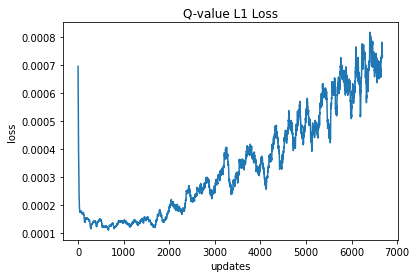

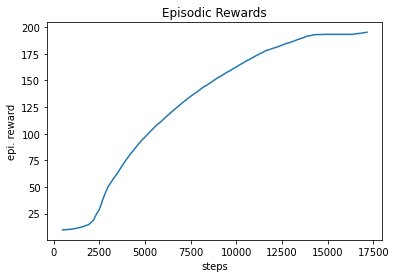

In [ ]:
plt.plot(moving_average(losses, 100))
plt.title("Q-value L1 Loss")
plt.xlabel("updates")
plt.ylabel("loss")
plt.show()

print()

plt.plot(moving_average(episode_steps, 100), moving_average(episode_rewards, 100))

plt.title("Episodic Rewards")
plt.xlabel("steps")
plt.ylabel("epi. reward")
plt.show()

Visualization

In [ ]:
env = gym.make('CartPole-v0')
env = Monitor(env, './video', force=True)
rewards = 0.0

ob, done = env.reset(), False
while not done:
    action = online_net(torch.FloatTensor(ob)).argmax().item()
    ob, reward, done, info = env.step(action)
    rewards += reward
env.close()

print(f"\nEpisode Finished! Reward: {rewards:.1f}.  Please wait until GIF Video is created...")
show_video()

/usr/local/lib/python3.7/dist-packages/gym/envs/registration.py:506: UserWarning: WARN: The environment CartPole-v0 is out of date. You should consider upgrading to version `v1` with the environment ID `CartPole-v1`.
  f"The environment {path} is out of date. You should consider "



Episode Finished! Reward: 200.0.  Please wait until GIF Video is created...


### N-Step Experience Replay


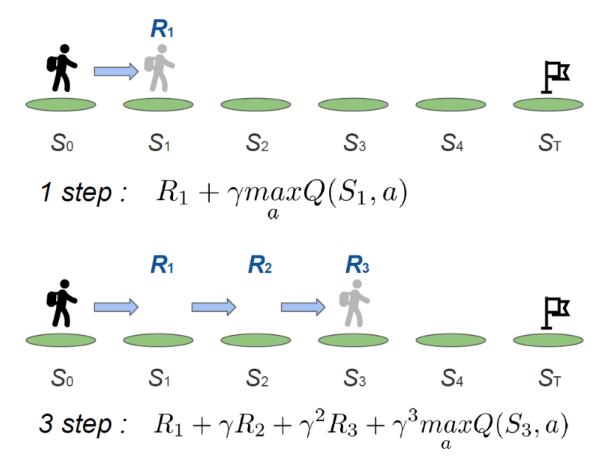

In [ ]:
class ReplayMemory:
    def __init__(self, buffer_size=50000, n_steps=4, discount_rate=0.99):
        self.buffer = deque(maxlen=buffer_size)
        self.n_steps = n_steps
        self.n_step_buffer = deque(maxlen=n_steps)
        self.discount_rate = discount_rate
    
    
    def write(self, state, action, reward, next_state, done):
        self.n_step_buffer.append((state, action, reward, next_state, done))

        if len(self.n_step_buffer) == self.n_steps:
            # 첫번째 step
            start_step = self.n_step_buffer[0]
            # 마지막 step
            last_step = self.n_step_buffer[-1]

            reward = 0
            done = False
            # N step 동안의 reward를 더합니다.
            # Discount rate을 반영하여 계산합니다.
            for data in reversed(self.n_step_buffer):
                # r = gamma*r'*(1-done) + reward
                reward = self.discount_rate * reward * (1-done) + data[2] ###

                if data[4]:
                    # 중간에 환경이 끝났으면 끝난 정보를 저장합니다.
                    done = True
            # Buffer에 (첫번째 step의 state, 첫번째 step의 action, reward 합, 마지막 step의 next_state, n step 도중 끝났는지) tuple을 저장합니다.
            self.buffer.append((start_step[0], start_step[1], reward, last_step[3], done)) ###


    # Sample 함수는 동일
    def sample(self, sample_size=32):
        sample_indices = np.random.choice(len(self.buffer), size=sample_size, replace=False)
        
        states, actions, rewards, next_states, dones = (list() for _ in range(5))
        
        for index in sample_indices:
            sample = self.buffer[index]
            states.append(sample[0])
            actions.append(sample[1])
            rewards.append(sample[2])
            next_states.append(sample[3])
            dones.append(sample[4])
            
        return states, actions, rewards, next_states, dones

In [ ]:
# N step과 Double DQN 적용
n_steps = 8 # 추천: 2 ~ 16


# 환경, 변수 초기화
env = gym.make("CartPole-v0")

replay_memory = ReplayMemory(buffer_size=memory_size, n_steps=n_steps, discount_rate=discount_rate)

online_net = QNetwork()
target_net = QNetwork()
target_net.load_state_dict(online_net.state_dict())  # Target Net의 파라미터를 Online Net의 파라미터로 바꿔줍니다.

optimizer = torch.optim.Adam(online_net.parameters(), lr=learning_rate)

ndqn_losses = []
episode_reward = 0.0
ndqn_episode_rewards = []
ndqn_episode_steps = []


print("Experience Replay Warmup...")

# 환경을 초기화하고 State를 받습니다.
state, done = env.reset(), False

for warmup_step in tqdm.trange(warmup_steps):
    action = env.action_space.sample()  # 무작위 Action을 선택합니다.
    next_state, reward, done, _ = env.step(action)  # Action을 취하고 다음 State, 보상, 에피소드 종료 여부를 받습니다.
    
    replay_memory.write(state, action, reward/100, next_state, done)  # Replay Memory에 Transition을 써줍니다.
    
    if done:  # 에피소드가 끝났다면,
        state = env.reset()  # 환경을 초기화합니다.
    else:  # 아니라면,
        state = next_state  # 현재 State를 업데이트 해줍니다.

Experience Replay Warmup...


100%|██████████| 10000/10000 [00:00<00:00, 43763.01it/s]


In [ ]:
from torch._C import NoneType
print("DQN Training Starts...")
progress_bar = tqdm.trange(train_steps)

# 환경 초기화, 현재 State를 받아옵니다.
state, done = env.reset(), False

for step in progress_bar:
    online_net.eval()

    # Epsilon-Greedy
    if np.random.random() < epsilon:   
        action = env.action_space.sample()  # 랜덤 action
    else:
        action = online_net(torch.FloatTensor(state)).argmax().item()


    # 선택된 Action을 이용해 환경과 상호작용합니다.
    next_state, reward, done, _ = env.step(action)
    
    # Replay Memory에 Transition을 넣어줍니다.
    replay_memory.write(state, action, reward/100, next_state, done)

    # Episode Reward를 기록합니다. (학습 진행상황 확인용)
    episode_reward += reward
    
    if done:
        state = env.reset()
        ndqn_episode_rewards.append(episode_reward)
        ndqn_episode_steps.append(step)
        episode_reward = 0.0
    else:
        state = next_state
    
    # Train Step
    if step % train_freq == 0:
        online_net.train()
        # Replay Memory에서 minibatch를 샘플링해옵니다.
        states, actions, rewards, next_states, dones = replay_memory.sample(batch_size)

        states = torch.FloatTensor(np.array(states))  # shape: (Batch, 4)
        actions = torch.LongTensor(np.array(actions))  # shape: (Batch,)
        rewards = torch.FloatTensor(np.array(rewards))  # shape: (Batch,)
        next_states = torch.FloatTensor(np.array(next_states))  # shape: (Batch, 4)
        dones = torch.FloatTensor(np.array(dones))  # shape: (Batch,)
        

        # TD Target을 계산합니다.
        with torch.no_grad():
            next_q_values = target_net(next_states).max(axis=-1)[0]
            target_q_values = rewards + discount_rate * next_q_values * (1.0 - dones)

        # Online Net의 Q값을 계산합니다. Q(s, a)이기 때문에,
        # torch.gather를 이용해 action으로 indexing해 해당 action의 Q값을.가져와야 합니다.
        current_q_values = online_net(states).gather(1, actions.unsqueeze(-1)).squeeze()
        

        # Online Net의 Q값과 TD Target 간의 Loss를 계산합니다.
        loss = F.smooth_l1_loss(current_q_values, target_q_values)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        ndqn_losses.append(loss.item())

    # 일정 Step 마다 Target Network의 파라미터를 Online Network의 그것으로 갱신해줍니다.
    if step % target_update_freq == target_update_freq - 1:
        target_net.load_state_dict(online_net.state_dict())
        
    # 학습 과정 출력
    if step % 100 == 99:
        avg_rew = np.mean(ndqn_episode_rewards[-100:])
        progress_bar.set_description(f"loss: {np.mean(ndqn_losses[-100:]):6.4f}, epi. rew.: {avg_rew:5.1f}, max_rew.: {np.max(ndqn_episode_rewards):5.1f}")

        if avg_rew > target_score:
            break

DQN Training Starts...


loss: 0.0150, epi. rew.: 195.8, max_rew.: 200.0:  20%|██        | 20399/100000 [00:11<00:43, 1838.46it/s]


### DQN v.s. Multi-Step DQN 결과 비교


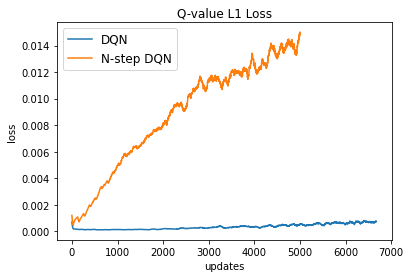

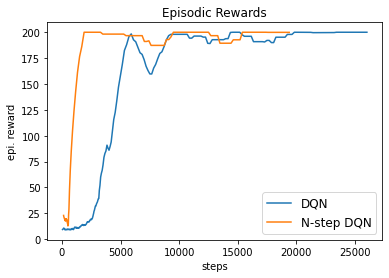

In [ ]:
plt.plot(moving_average(losses, 100), label='DQN')
plt.plot(moving_average(ndqn_losses, 100), label='N-step DQN')
plt.title("Q-value L1 Loss")
plt.xlabel("updates")
plt.ylabel("loss")
plt.legend(fontsize=12)
plt.show()

print()

plt.plot(moving_average(episode_steps, 10), moving_average(episode_rewards, 10), label='DQN')
plt.plot(moving_average(ndqn_episode_steps, 10), moving_average(ndqn_episode_rewards, 10), label='N-step DQN')

plt.title("Episodic Rewards")
plt.xlabel("steps")
plt.ylabel("epi. reward")
plt.legend(fontsize=12)
plt.show()

In [ ]:
env = gym.make('CartPole-v0')
env = Monitor(env, './video', force=True)

rewards = 0.0

ob, done = env.reset(), False
while not done:
    action = online_net(torch.FloatTensor(ob)).argmax().item()
    ob, reward, done, info = env.step(action)
    rewards += reward
env.close()

print(f"\nEpisode Finished! Reward: {rewards:.1f}")
show_video()


Episode Finished! Reward: 200.0


# Stable Baseline 3

Stable Baseline 3는 다양한 강화학습 알고리즘을 쉽게 돌려볼 수 있도록 제공하는 library입니다.

Day 2에 SB3로 다양한 알고리즘을 활용하기 앞서 DQN을 돌려보도록 하겠습니다.

In [ ]:
!pip install stable-baselines3

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


LunarLander-v2는 우주선을 목적지에 안전하게 착륙시켜야 하는 환경입니다.

우주선의 위치, 속도가 입력으로 주어지고, 액션인 좌, 우, 아래 엔진을 잘 출력하여 우주선을 가운데 착륙지점에 잘 착륙시켜야 합니다.

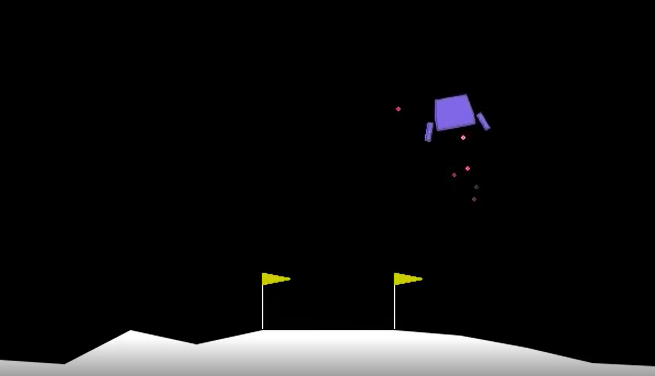


In [ ]:
from stable_baselines3 import DQN
from stable_baselines3.common.logger import configure
from stable_baselines3.common.callbacks import BaseCallback, EvalCallback, StopTrainingOnRewardThreshold

# OpenAI Gym Style을 따르는 환경들은 모두 사용 가능합니다.
env = gym.make('LunarLander-v2')


# 평가용 환경 (training 환경하고 분리)
eval_env = gym.make("LunarLander-v2")
eval_env = Monitor(eval_env, './video', force=True)

# 모델이 특정 점수를 넘기면 학습을 종료시키는 Callback function : 어떤 조건에 도달시 그때 어떤 event가 발생
callback_on_best = StopTrainingOnRewardThreshold(reward_threshold=200, verbose=1)

# evaluation 후 evaluation 영상을 보여주는 callback
class VideoCallback(BaseCallback):
    def __init__(self, verbose=0):
        super().__init__(verbose)
    
    def _on_step(self):
        show_video()
        return True

# 매 10000 step마다 모델을 평가하는 callback
eval_callback = EvalCallback(
    eval_env, 
    n_eval_episodes=5,
    eval_freq=20000, 
    deterministic=True,
    callback_on_new_best=callback_on_best,
    callback_after_eval=VideoCallback(),
    verbose=1
    )

# 모델 생성 및 설정
model = DQN(
    env=env,
    policy='MlpPolicy',
    learning_rate=0.00063,
    batch_size=128,
    buffer_size=50000,
    learning_starts=0,
    gamma=0.99,
    target_update_interval=250,
    train_freq=4,
    gradient_steps=-1,
    exploration_fraction=0.12,
    exploration_final_eps=0.1,
    policy_kwargs=dict(net_arch=[256, 256]),
    verbose=0,
    seed=10,
)

# 학습 로그 저장 설정
log_path = './log/dqn_lunarlander'
new_logger = configure(log_path, ['stdout', 'csv'])
model.set_logger(new_logger)

# 모델 학습과 저장
model.learn(total_timesteps=100000, callback=eval_callback)
model.save("dqn_lunarlander")


Logging to ./log/dqn_lunarlander
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 86.8     |
|    ep_rew_mean      | -147     |
|    exploration_rate | 0.974    |
| time/               |          |
|    episodes         | 4        |
|    fps              | 211      |
|    time_elapsed     | 1        |
|    total_timesteps  | 347      |
| train/              |          |
|    learning_rate    | 0.00063  |
|    loss             | 1.45     |
|    n_updates        | 344      |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 87.4     |
|    ep_rew_mean      | -187     |
|    exploration_rate | 0.948    |
| time/               |          |
|    episodes         | 8        |
|    fps              | 215      |
|    time_elapsed     | 3        |
|    total_timesteps  | 699      |
| train/              |          |
|    learning_rate    | 0.00063  |
|    loss             

Visualization

In [ ]:
# 학습된 모델 불러오기
model = DQN.load("dqn_lunarlander", env=env)
env = gym.make('LunarLander-v2')
env = Monitor(env, './video', force=True)

rewards = 0.0

ob, done = env.reset(), False
while not done:
    action, _ = model.predict(ob)
    ob, reward, done, info = env.step(action)
    rewards += reward
env.close()

print(f"\nEpisode Finished! Reward: {rewards:.1f}.")
show_video()

FileNotFoundError: ignored